In [4]:

# Import necessary libraries
import numpy as np 
import pandas as pd
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import sklearn
import pydicom
from pydicom.data import get_testdata_file


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [5]:
data_dir = '/kaggle/input/rsna-2023-abdominal-trauma-detection/'

In [6]:
train_df = pd.read_csv(os.path.join(data_dir, "train.csv"))

In [7]:
train_df.head()

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1
1,10005,1,0,1,0,1,0,0,1,0,0,1,0,0,0
2,10007,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3,10026,1,0,1,0,1,0,0,1,0,0,1,0,0,0
4,10051,1,0,1,0,1,0,0,1,0,0,0,1,0,1


In [8]:
train_series_df = pd.read_csv(os.path.join(data_dir, "train_series_meta.csv"))

In [9]:
train_series_df.head()

,patient_id,series_id,aortic_hu,incomplete_organ
0,10004,21057,146.00,0
1,10004,51033,454.75,0
2,10005,18667,187.00,0
3,10007,47578,329.00,0
4,10026,29700,327.00,0


In [10]:
imag_df = pd.read_csv(os.path.join(data_dir, "image_level_labels.csv"))
imag_df

,patient_id,series_id,instance_number,injury_name
0,10004,21057,362,Active_Extravasation
1,10004,21057,363,Active_Extravasation
2,10004,21057,364,Active_Extravasation
3,10004,21057,365,Active_Extravasation
4,10004,21057,366,Active_Extravasation
...,...,...,...,...
12024,9632,3750,155,Active_Extravasation
12025,9632,3750,156,Active_Extravasation
12026,9632,3750,157,Active_Extravasation
12027,9632,3750,158,Active_Extravasation


In [11]:
s= pd.read_csv(os.path.join(data_dir, "sample_submission.csv"))
s

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high
0,48843,0.5,0.5,0.5,0.5,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333
1,50046,0.5,0.5,0.5,0.5,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333
2,63706,0.5,0.5,0.5,0.5,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333


# EDA on the train data

In [12]:
data = train_df
data.head()

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1
1,10005,1,0,1,0,1,0,0,1,0,0,1,0,0,0
2,10007,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3,10026,1,0,1,0,1,0,0,1,0,0,1,0,0,0
4,10051,1,0,1,0,1,0,0,1,0,0,0,1,0,1


In [13]:
summary_statistics = data.describe()
summary_statistics.iloc[1]

patient_id               32664.239593
bowel_healthy                0.979663
bowel_injury                 0.020337
extravasation_healthy        0.936447
extravasation_injury         0.063553
kidney_healthy               0.942167
kidney_low                   0.036543
kidney_high                  0.021290
liver_healthy                0.897998
liver_low                    0.082301
liver_high                   0.019701
spleen_healthy               0.887512
spleen_low                   0.063235
spleen_high                  0.049253
any_injury                   0.271687
Name: mean, dtype: float64

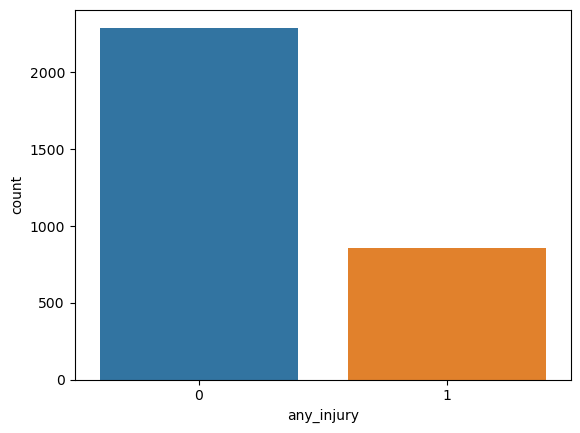

In [14]:
sns.countplot(data=data, x='any_injury');

It seems that 27% had injuries.


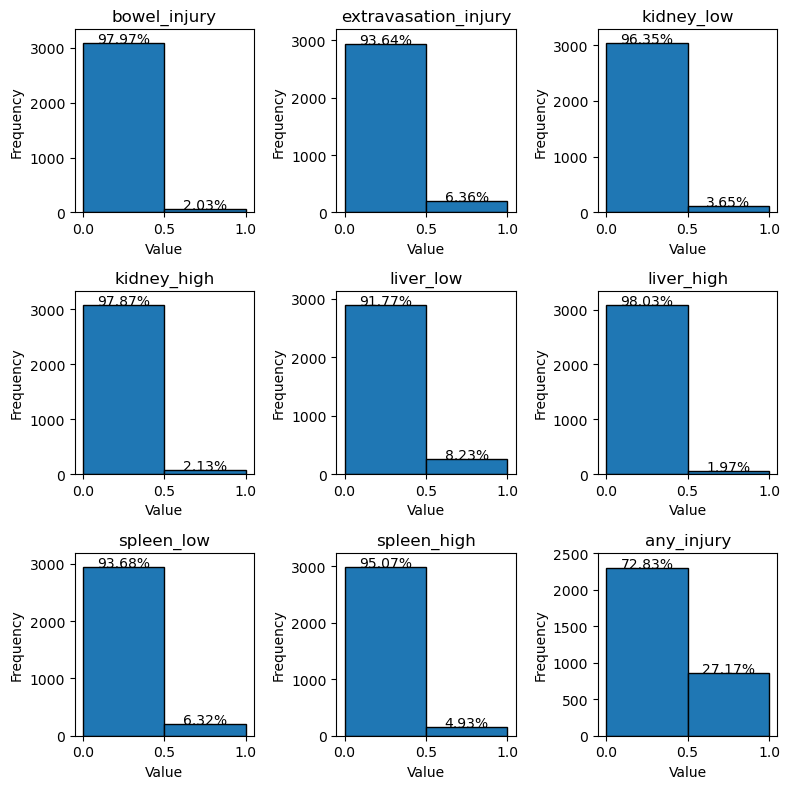

In [15]:

injury_columns = [
    "bowel_injury", "extravasation_injury",
    "kidney_low", "kidney_high", 
    "liver_low", "liver_high",
    "spleen_low", "spleen_high",
    "any_injury"
]

# Create a grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

# Flatten the 2D axes array to make it easier to iterate
axes = axes.flatten()

# Iterate over the columns in injury_columns and plot histograms
for i, col in enumerate(injury_columns):
    data[col].plot(kind='hist', bins=2, edgecolor='k', ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
     # Calculate and add frequencies as percentages
    total_count = len(data[col])
    for patch in axes[i].patches:
        height = patch.get_height()
        x = patch.get_x() + patch.get_width() / 2
        percentage = (height / total_count) * 100
        axes[i].annotate(f'{percentage:.2f}%', (x, height), ha='center')
    # Extend the x-axis limits
    y_min, y_max = axes[i].get_ylim()
    axes[i].set_ylim(y_min , y_max + 100)


# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


In [16]:
# Checking for missing values
missing_values = data.isnull().sum()
missing_values

patient_id               0
bowel_healthy            0
bowel_injury             0
extravasation_healthy    0
extravasation_injury     0
kidney_healthy           0
kidney_low               0
kidney_high              0
liver_healthy            0
liver_low                0
liver_high               0
spleen_healthy           0
spleen_low               0
spleen_high              0
any_injury               0
dtype: int64

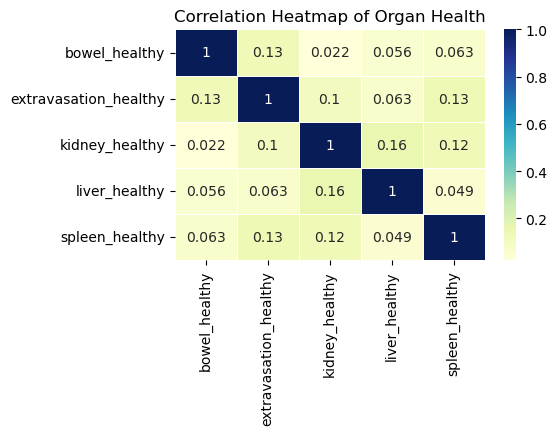

In [17]:
# Selecting columns related to the health of organs
health_columns = [
    "bowel_healthy", "extravasation_healthy", "kidney_healthy", 
    "liver_healthy", "spleen_healthy",
]

# Calculating the correlation matrix for the selected columns
correlation_matrix = data[health_columns].corr()

# Plotting the heatmap to visualize the correlations
plt.figure(figsize=(5, 3))
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu", linewidths=.5)
plt.title("Correlation Heatmap of Organ Health")
plt.show()

The correlations between different health columns are generally small, indicating that the healthy state of one organ might not be strongly related to the healthy state of other organs.

There is no strong correlation between any two specific health-related columns, suggesting that the health status of different organs is relatively independent of each other.

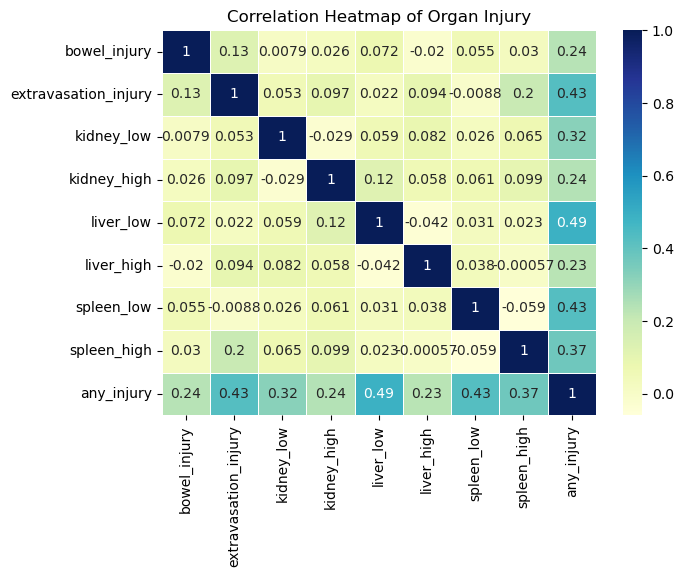

In [18]:
# Selecting columns related to the health of organs
injury_columns = [
    "bowel_injury", "extravasation_injury",
    "kidney_low", "kidney_high", 
    "liver_low", "liver_high",
    "spleen_low", "spleen_high",
    "any_injury"
]

# Calculating the correlation matrix for the selected columns
correlation_matrix = data[injury_columns].corr()

# Plotting the heatmap to visualize the correlations
plt.figure(figsize=(7, 5))
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu", linewidths=.5)
plt.title("Correlation Heatmap of Organ Injury")
plt.show()

Bowel and Extravasation:

**bowel_injury**: This shows a moderate correlation with any_injury (0.24) and a smaller correlation with extravasation_injury (0.13)

**extravasation_injury**: This has a strong correlation with any_injury (0.43) and a moderate correlation with spleen_high (0.200).

Kidney:

**kidney_low**: This is moderately correlated with any_injury (0.319).

**kidney_high**: Similar to kidney_low, this is moderately correlated with any_injury (0.24).

Liver:

**liver_low**: This has a strong correlation with any_injury (0.490).

**liver_high**: This shows a moderate correlation with any_injury (0.232).

Spleen:

**spleen_low**: This is moderately correlated with any_injury (0.425).

**spleen_high**: This shows a moderate correlation with any_injury (0.373) and extravasation_injury (0.200).


Conclusions: The any_injury column is moderately to strongly correlated with all other injury columns, suggesting that it may be a summary measure of injury presence across different organs.

There are some specific correlations between individual injury types, such as the correlation between extravasation_injury and spleen_high.

The correlations between the low and high levels of organ injuries (e.g., kidney_low and kidney_high) are generally lower, indicating that these might be independent conditions.

The correlation between different organs' injuries is generally low, which might suggest that injuries to different organs occur independently of each other.

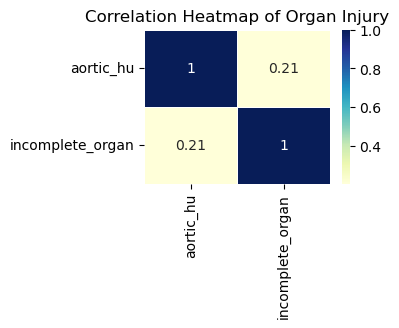

In [19]:
# Some extra correlation check
col=['aortic_hu','incomplete_organ']
correlation_matrix = train_series_df[col].corr()

# Plotting the heatmap to visualize the correlations
plt.figure(figsize=(3, 2))
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu", linewidths=.5)
plt.title("Correlation Heatmap of Organ Injury")
plt.show()

# Plotting the CT scans with labels of injured or not

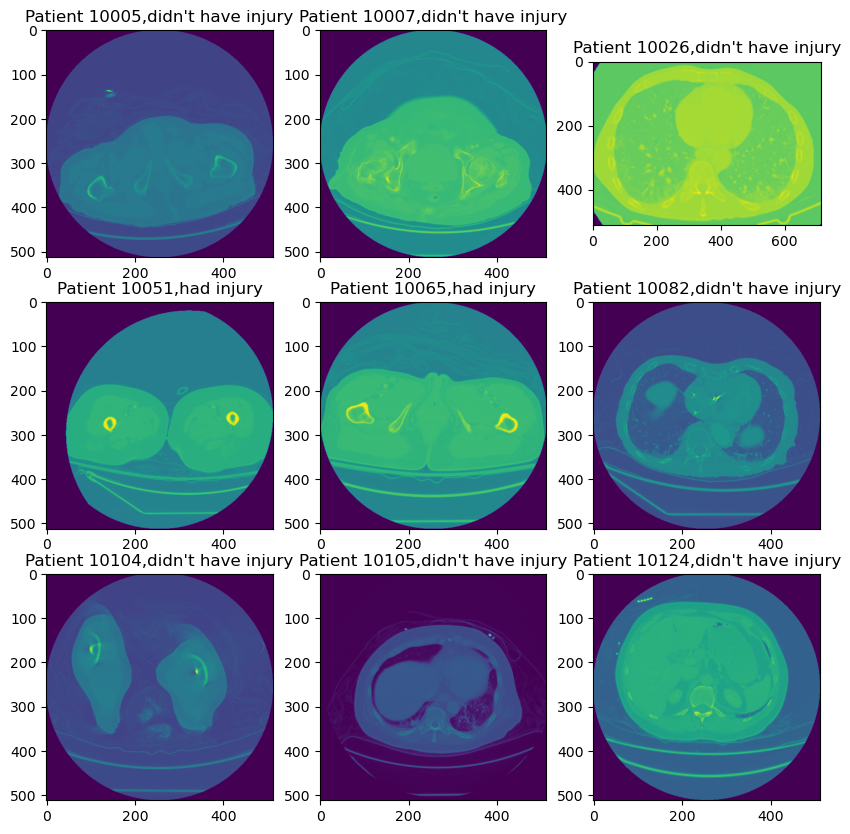

In [20]:
p_ids=list(train_df.patient_id.unique())
fig, ax = plt.subplots(3, 3, figsize=(10, 10))

for i in range(1,10):
    patient_id=p_ids[i]
    series_id=os.listdir(f'/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/{patient_id}')[0]
    os.listdir(f'/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/{patient_id}/{series_id}')
    img_id=os.listdir(f'/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/{patient_id}/{series_id}')[0]
    label=train_df[train_df.patient_id == int(patient_id)]['any_injury'][train_df[train_df.patient_id == int(patient_id)]['any_injury'].index[0]]
    img_path=f'/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/{patient_id}/{series_id}/{img_id}'

    dcm_img = pydicom.dcmread(img_path, force=True)
    img_array = dcm_img.pixel_array
    plt.imshow(img_array)
    if label == 0:
        category = "didn't have injury"
    elif label == 1:
        category = "had injury"
  
    q, r = divmod(i-1, 3)
        
    img_array = pydicom.dcmread(img_path, force=True).pixel_array
        
        
    ax[q][r].imshow(img_array)
    ax[q][r].set_title(f'Patient {patient_id},{category}')

In [21]:
image_labels = pd.read_csv(os.path.join(data_dir, "image_level_labels.csv"))
image_labels.injury_name.unique()

array(['Active_Extravasation', 'Bowel'], dtype=object)

# Building Model

In [22]:
train_df

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1
1,10005,1,0,1,0,1,0,0,1,0,0,1,0,0,0
2,10007,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3,10026,1,0,1,0,1,0,0,1,0,0,1,0,0,0
4,10051,1,0,1,0,1,0,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3142,9951,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3143,9960,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3144,9961,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3145,9980,1,0,1,0,1,0,0,1,0,0,0,0,1,1


In [23]:
imag_df

,patient_id,series_id,instance_number,injury_name
0,10004,21057,362,Active_Extravasation
1,10004,21057,363,Active_Extravasation
2,10004,21057,364,Active_Extravasation
3,10004,21057,365,Active_Extravasation
4,10004,21057,366,Active_Extravasation
...,...,...,...,...
12024,9632,3750,155,Active_Extravasation
12025,9632,3750,156,Active_Extravasation
12026,9632,3750,157,Active_Extravasation
12027,9632,3750,158,Active_Extravasation


In [24]:
dataframe = train_df.merge(imag_df, on='patient_id', how='inner')
dataframe

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury,series_id,instance_number,injury_name
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,362,Active_Extravasation
1,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,363,Active_Extravasation
2,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,364,Active_Extravasation
3,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,365,Active_Extravasation
4,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,366,Active_Extravasation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12024,9632,1,0,0,1,1,0,0,1,0,0,1,0,0,1,3750,155,Active_Extravasation
12025,9632,1,0,0,1,1,0,0,1,0,0,1,0,0,1,3750,156,Active_Extravasation
12026,9632,1,0,0,1,1,0,0,1,0,0,1,0,0,1,3750,157,Active_Extravasation
12027,9632,1,0,0,1,1,0,0,1,0,0,1,0,0,1,3750,158,Active_Extravasation


In [25]:
! pip install -q git+https://github.com/keras-team/keras-cv

In [26]:
import os
# You can use `tensorflow`, `pytorch`, `jax` here
# KerasCore makes the notebook backend agnostic :)
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras_cv
import keras_core as keras
from keras_core import layers

import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

Using TensorFlow backend


In [27]:
class Config:
    SEED = 42
    IMAGE_SIZE = [256, 256]
    BATCH_SIZE = 64
    EPOCHS = 10
    TARGET_COLS  = [
        "bowel_injury", "extravasation_injury",
        "kidney_healthy", "kidney_low", "kidney_high",
        "liver_healthy", "liver_low", "liver_high",
        "spleen_healthy", "spleen_low", "spleen_high",
    ]
    AUTOTUNE = tf.data.AUTOTUNE

config = Config()

In [28]:
keras.utils.set_random_seed(seed=config.SEED)

In [29]:
BASE_PATH = f"/kaggle/input/rsna-2023-abdominal-trauma-detection"
dataframe = pd.read_csv(f"{BASE_PATH}/train.csv")
dataframe = dataframe.merge(imag_df, on='patient_id', how='inner')
dataframe


,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury,series_id,instance_number,injury_name
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,362,Active_Extravasation
1,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,363,Active_Extravasation
2,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,364,Active_Extravasation
3,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,365,Active_Extravasation
4,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,366,Active_Extravasation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12024,9632,1,0,0,1,1,0,0,1,0,0,1,0,0,1,3750,155,Active_Extravasation
12025,9632,1,0,0,1,1,0,0,1,0,0,1,0,0,1,3750,156,Active_Extravasation
12026,9632,1,0,0,1,1,0,0,1,0,0,1,0,0,1,3750,157,Active_Extravasation
12027,9632,1,0,0,1,1,0,0,1,0,0,1,0,0,1,3750,158,Active_Extravasation


In [30]:
dataframe

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury,series_id,instance_number,injury_name
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,362,Active_Extravasation
1,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,363,Active_Extravasation
2,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,364,Active_Extravasation
3,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,365,Active_Extravasation
4,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,366,Active_Extravasation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12024,9632,1,0,0,1,1,0,0,1,0,0,1,0,0,1,3750,155,Active_Extravasation
12025,9632,1,0,0,1,1,0,0,1,0,0,1,0,0,1,3750,156,Active_Extravasation
12026,9632,1,0,0,1,1,0,0,1,0,0,1,0,0,1,3750,157,Active_Extravasation
12027,9632,1,0,0,1,1,0,0,1,0,0,1,0,0,1,3750,158,Active_Extravasation


In [31]:
# from pathlib import Path
# import pydicom
# from PIL import Image

# # Define the RESIZE_TO variable
# RESIZE_TO = (256, 256)  # Adjust the size as needed

# # Function to process a single DICOM file and save it as a PNG
# def process_dicom_file(dicom_file_path, output_directory):
#     dicom_file = pydicom.dcmread(dicom_file_path)
#     processed_ary = dicom_file.pixel_array
#     im = Image.fromarray(processed_ary).resize(RESIZE_TO)
    
#     # Create the output directory structure based on input file's path
#     output_subdirectory = output_directory / dicom_file_path.parent.relative_to(input_directory)
#     output_subdirectory.mkdir(parents=True, exist_ok=True)
    
#     # Save the processed PNG image
#     output_file_path = output_subdirectory / f"{dicom_file_path.stem}.png"
#     im.save(output_file_path)
#     #print(f"Processed and saved: {output_file_path}")

# # Define the input directory path
# input_directory = Path('/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/')

# # Define the output directory for processed images 
# output_directory = Path('png_train_images')

# # Create the output directory if it doesn't exist
# output_directory.mkdir(parents=True, exist_ok=True)

# # Loop through patient_id/series_id/image.dcm directory structure
# for patient_id_directory in input_directory.iterdir():
#     if patient_id_directory.is_dir():
#         for series_id_directory in patient_id_directory.iterdir():
#             if series_id_directory.is_dir():
#                 for image_dcm in series_id_directory.iterdir():
#                     if image_dcm.is_file() and image_dcm.suffix == '.dcm':
#                         process_dicom_file(image_dcm, output_directory)


In [32]:
# from pathlib import Path
# import pydicom
# from PIL import Image
# import multiprocessing as mp

# # Define the RESIZE_TO variable
# RESIZE_TO = (256, 256)  # Adjust the size as needed

# # Function to process a single DICOM file and save it as a PNG
# def process_dicom_file(dicom_file_path, output_directory):
#     dicom_file = pydicom.dcmread(dicom_file_path)
#     processed_ary = dicom_file.pixel_array
#     im = Image.fromarray(processed_ary).resize(RESIZE_TO)
    
#     # Create the output directory structure based on input file's path
#     output_subdirectory = output_directory / dicom_file_path.parent.relative_to(input_directory)
#     output_subdirectory.mkdir(parents=True, exist_ok=True)
    
#     # Save the processed PNG image
#     output_file_path = output_subdirectory / f"{dicom_file_path.stem}.png"
#     im.save(output_file_path)
#     #print(f"Processed and saved: {output_file_path}")

# # Define the input directory path
# input_directory = Path('/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/')

# # Define the output directory for processed images 
# output_directory = Path('png_train_images')

# # Create the output directory if it doesn't exist
# output_directory.mkdir(parents=True, exist_ok=True)

# # Function to process a series of DICOM files in a directory
# def process_series(series_directory):
#     for image_dcm in series_directory.glob('*.dcm'):
#         if image_dcm.is_file() and image_dcm.suffix == '.dcm':
#             process_dicom_file(image_dcm, output_directory)

# # Use multiprocessing for parallel processing
# with mp.Pool() as pool:
#     for patient_id_directory in input_directory.iterdir():
#         if patient_id_directory.is_dir():
#             for series_id_directory in patient_id_directory.iterdir():
#                 if series_id_directory.is_dir():
#                     pool.apply_async(process_series, args=(series_id_directory,))
    
#     pool.close()
#     pool.join()


In [33]:
image_dir_pydicom = '/kaggle/working/png_file_py/'
image_dir_dicomsdl = '/kaggle/working/png_file_dic/'

os.makedirs(image_dir_pydicom, exist_ok=True)
os.makedirs(image_dir_dicomsdl, exist_ok=True)

IMAGES_TO_PROCESS = 500

In [34]:
train_images = glob.glob("/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/*/*/*.dcm")
len(train_images)

1500653

In [35]:
def process(f, size=512, save_folder=None, dicom_process = True, extension="png"):
    
    patient = f.split('/')[-3]
    series = f.split('/')[-2]
    image_name = f.split('/')[-1][:-4]
    if dicom_process:
        dicom = pydicom.dcmread(f)
        img = dicom.pixel_array

        img = (img - img.min()) / (img.max() - img.min())

        if dicom.PhotometricInterpretation == "MONOCHROME1":  
            img = 1 - img
            
        image = (img * 255).astype(np.uint8)
    else:
        
        dicom = dicoml.open(f)
        img = dicom.pixelData()

        img = (img - img.min()) / (img.max() - img.min())

        if dicom.getPixelDataInfo()['PhotometricInterpretation'] == "MONOCHROME1":
            img = 1 - img

        image = (img * 255).astype(np.uint8)
    
    img = cv2.resize(image, (size, size))

   # file_name = f'{save_folder}' + f"{patient}/{series}/{image_name}.{extension}"
    # Construct the output directory path
    output_directory = os.path.join(save_folder, patient, series)

    # Ensure the output directory exists
    os.makedirs(output_directory, exist_ok=True)

    # Construct the full file path, including the extension
    file_name = os.path.join(output_directory, f"{image_name}.{extension}")

    # Save the processed image with the correct file name and path
    cv2.imwrite(file_name, img)

   


In [45]:
%%capture

!pip install /kaggle/input/rsnamodules/dicomsdl-0.109.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl 

try:
    import pylibjpeg
except:
   !pip install /kaggle/input/rsna-2022-whl/{pylibjpeg-1.4.0-py3-none-any.whl,python_gdcm-3.0.15-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl}

For transforming dicom image to png https://www.kaggle.com/code/remekkinas/fast-dicom-processing-1-6-2x-faster

In [66]:

#import dicomsdl as dicoml
import cv2
import pydicom

from joblib import Parallel, delayed
import glob
import time
import numpy as np
import os
from matplotlib import pyplot as plt
# start_time = time.time()
        
# Parallel(n_jobs=4)(
#     delayed(process)(f, size = 512, save_folder = image_dir_pydicom, dicom_process = True)
#     for f in train_images#[:IMAGES_TO_PROCESS]
# )

# print(time.time() - start_time)

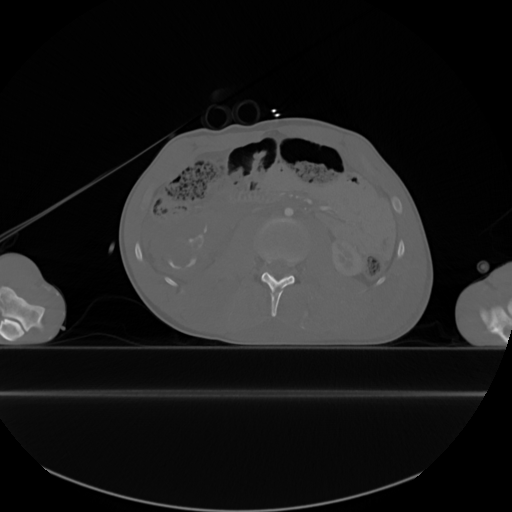

In [58]:
from IPython.display import Image, display

# Specify the path to the image
image_path = "/kaggle/working/png_file_py/32272/13774/61.png"

# Display the image in the notebook
display(Image(filename=image_path))

In [39]:
image_dir_pydicom

'/kaggle/working/png_file_py/'

file /kaggle/working/png_file_py/13182/45080/299.png size in bytes: 62861, shape: (512, 512, 3)


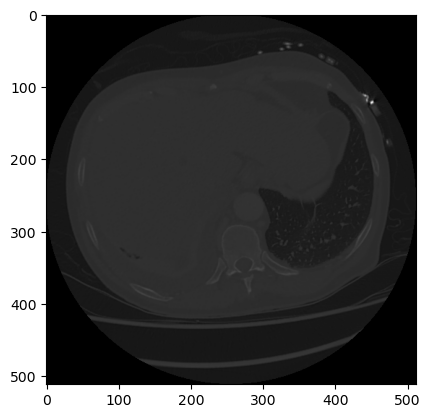

file /kaggle/working/png_file_py/13182/45080/597.png size in bytes: 84281, shape: (512, 512, 3)


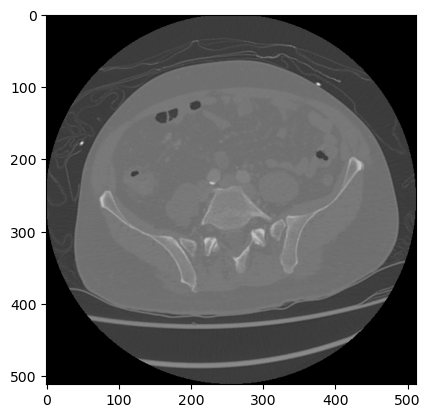

file /kaggle/working/png_file_py/13182/45080/465.png size in bytes: 83488, shape: (512, 512, 3)


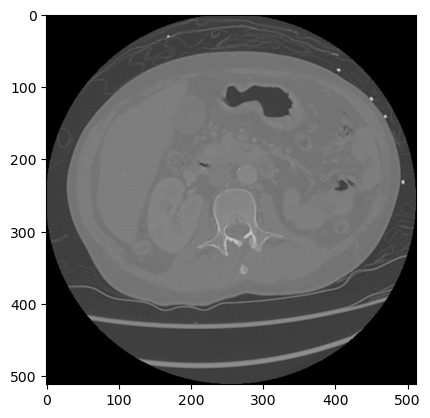

file /kaggle/working/png_file_py/13182/45080/667.png size in bytes: 85912, shape: (512, 512, 3)


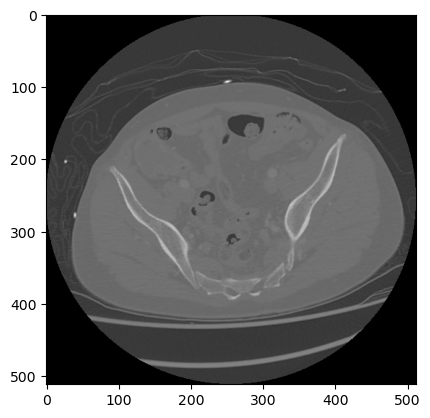

In [49]:
out_files = glob.glob(f'{image_dir_pydicom}/*/*/*.png')
for idx, i in enumerate(out_files[:4]):
    im = cv2.imread(i)
    print(f'file {i} size in bytes: {os.path.getsize(i)}, shape: {im.shape}')
    plt.imshow(im)
    plt.show() 

In [56]:
dataframe['image_path']= '/kaggle/working/png_file_py'\
                   + "/" + dataframe.patient_id.astype(str)\
                    + "/" + dataframe.series_id.astype(str)\
                    + "/" + dataframe.instance_number.astype(str) +".png"

print("Before dropping duplicates:", dataframe.shape)
dataframe = dataframe.drop_duplicates()
# Create a boolean mask to identify rows with existing image paths
mask = dataframe['image_path'].apply(lambda x: os.path.exists(x))

# Use the mask to filter the DataFrame and keep only rows with valid image paths
dataframe = dataframe[mask]

#dataframe = dataframe.drop_duplicates(subset=['series_id', 'instance_number'])

print("After dropping duplicates:", dataframe.shape)


#dataframe.head(2)

Before dropping duplicates: (12029, 19)
After dropping duplicates: (1471, 19)


In [57]:
dataframe[(dataframe['instance_number'] == 61) & (dataframe['patient_id'] == 32272)]

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury,series_id,instance_number,injury_name,image_path
4431,32272,1,0,0,1,0,0,1,0,0,1,0,0,1,1,13774,61,Active_Extravasation,/kaggle/working/png_file_py/32272/13774/61.png


In [52]:
x=dataframe[(dataframe['instance_number'] == 61) & (dataframe['patient_id'] == 32272)].image_path[4431]
x

'/kaggle/working/png_file_py/32272/13774/61.png'

In [53]:
dataframe.image_path[0]

'/kaggle/working/png_file_py/10004/21057/362.png'

In [59]:
# Function to handle the split for each group
def split_group(group, test_size=0.2):
    if len(group) == 1:
        return (group, pd.DataFrame()) if np.random.rand() < test_size else (pd.DataFrame(), group)
    else:
        return train_test_split(group, test_size=test_size, random_state=42)

# Initialize the train and validation datasets
train_data = pd.DataFrame()
val_data = pd.DataFrame()

# Iterate through the groups and split them, handling single-sample groups
for _, group in dataframe.groupby(config.TARGET_COLS):
    train_group, val_group = split_group(group)
    train_data = pd.concat([train_data, train_group], ignore_index=True)
    val_data = pd.concat([val_data, val_group], ignore_index=True)

In [60]:
train_data.shape, val_data.shape

((1171, 19), (300, 19))

In [61]:
def decode_image_and_label(image_path, label):
    file_bytes = tf.io.read_file(image_path)
    image = tf.io.decode_png(file_bytes, channels=3, dtype=tf.uint8)
    image = tf.image.resize(image, config.IMAGE_SIZE, method="bilinear")
    image = tf.cast(image, tf.float32) / 255.0
    
    label = tf.cast(label, tf.float32)
    #         bowel       fluid       kidney      liver       spleen
    labels = (label[0:1], label[1:2], label[2:5], label[5:8], label[8:11])
    
    return (image, labels)


def apply_augmentation(images, labels):
    augmenter = keras_cv.layers.Augmenter(
        [
            keras_cv.layers.RandomFlip(mode="horizontal_and_vertical"),
            keras_cv.layers.RandomCutout(height_factor=0.2, width_factor=0.2),
            
        ]
    )
    return (augmenter(images), labels)


def build_dataset(image_paths, labels):
    ds = (
        tf.data.Dataset.from_tensor_slices((image_paths, labels))
        .map(decode_image_and_label, num_parallel_calls=config.AUTOTUNE)
        .shuffle(config.BATCH_SIZE * 10)
        .batch(config.BATCH_SIZE)
        .map(apply_augmentation, num_parallel_calls=config.AUTOTUNE)
        .prefetch(config.AUTOTUNE)
    )
    return ds

In [63]:
paths  = train_data.image_path.tolist()
labels = train_data[config.TARGET_COLS].values

ds = build_dataset(image_paths=paths, labels=labels)
images, labels = next(iter(ds))
images.shape, [label.shape for label in labels]

(TensorShape([64, 256, 256, 3]),
 [TensorShape([64, 1]),
  TensorShape([64, 1]),
  TensorShape([64, 3]),
  TensorShape([64, 3]),
  TensorShape([64, 3])])

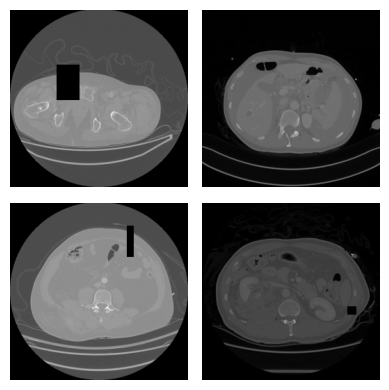

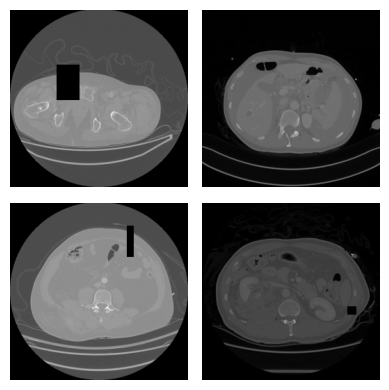

In [64]:
# No more customizing your plots by hand, KerasCV has your back ;)
keras_cv.visualization.plot_image_gallery(
    images=images,
    value_range=(0, 1),
    rows=2,
    cols=2,
)

# **Build Model**

In [67]:
# I will use this model:keras-io/deeplabv3p-resnet50
#     https://huggingface.co/keras-io/deeplabv3p-resnet50

In [71]:
def build_model(warmup_steps, decay_steps):
    # Define Input
    inputs = keras.Input(shape=config.IMAGE_SIZE + [3,], batch_size=config.BATCH_SIZE)
    
    # Define Backbone
    backbone = keras_cv.models.ResNetBackbone.from_preset("resnet50_imagenet")
    backbone.include_rescaling = False
    x = backbone(inputs)
    
    # GAP to get the activation maps
    gap = keras.layers.GlobalAveragePooling2D()
    x = gap(x)

    # Define 'necks' for each head
    x_bowel = keras.layers.Dense(32, activation='silu')(x)
    x_extra = keras.layers.Dense(32, activation='silu')(x)
    x_liver = keras.layers.Dense(32, activation='silu')(x)
    x_kidney = keras.layers.Dense(32, activation='silu')(x)
    x_spleen = keras.layers.Dense(32, activation='silu')(x)

    # Define heads
    out_bowel = keras.layers.Dense(1, name='bowel', activation='sigmoid')(x_bowel) # use sigmoid to convert predictions to [0-1]
    out_extra = keras.layers.Dense(1, name='extra', activation='sigmoid')(x_extra) # use sigmoid to convert predictions to [0-1]
    out_liver = keras.layers.Dense(3, name='liver', activation='softmax')(x_liver) # use softmax for the liver head
    out_kidney = keras.layers.Dense(3, name='kidney', activation='softmax')(x_kidney) # use softmax for the kidney head
    out_spleen = keras.layers.Dense(3, name='spleen', activation='softmax')(x_spleen) # use softmax for the spleen head
    
    # Concatenate the outputs
    outputs = [out_bowel, out_extra, out_liver, out_kidney, out_spleen]

    # Create model
    print("[INFO] Building the model...")
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    # Cosine Decay
    cosine_decay = keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=1e-4,
        decay_steps=decay_steps,
        alpha=0.0,
        warmup_target=1e-3,
        warmup_steps=warmup_steps,
    )

    # Compile the model
    optimizer = keras.optimizers.Adam(learning_rate=cosine_decay)
    loss = {
        "bowel":keras.losses.BinaryCrossentropy(),
        "extra":keras.losses.BinaryCrossentropy(),
        "liver":keras.losses.CategoricalCrossentropy(),
        "kidney":keras.losses.CategoricalCrossentropy(),
        "spleen":keras.losses.CategoricalCrossentropy(),
    }
    metrics = {
        "bowel":["accuracy"],
        "extra":["accuracy"],
        "liver":["accuracy"],
        "kidney":["accuracy"],
        "spleen":["accuracy"],
    }
    print("[INFO] Compiling the model...")
    model.compile(
        optimizer=optimizer,
      loss=loss,
      metrics=metrics
    )
    
    return model


In [72]:
# get image_paths and labels
print("[INFO] Building the dataset...")
train_paths = train_data.image_path.values; train_labels = train_data[config.TARGET_COLS].values.astype(np.float32)
valid_paths = val_data.image_path.values; valid_labels = val_data[config.TARGET_COLS].values.astype(np.float32)

# train and valid dataset
train_ds = build_dataset(image_paths=train_paths, labels=train_labels)
val_ds = build_dataset(image_paths=valid_paths, labels=valid_labels)

total_train_steps = train_ds.cardinality().numpy() * config.BATCH_SIZE * config.EPOCHS
warmup_steps = int(total_train_steps * 0.10)
decay_steps = total_train_steps - warmup_steps

print(f"{total_train_steps=}")
print(f"{warmup_steps=}")
print(f"{decay_steps=}")


[INFO] Building the dataset...
total_train_steps=12160
warmup_steps=1216
decay_steps=10944


In [73]:
# build the model
print("[INFO] Building the model...")
model = build_model(warmup_steps, decay_steps)

# train
print("[INFO] Training...")
history = model.fit(
    train_ds,
    epochs=config.EPOCHS,
    validation_data=val_ds,
)

[INFO] Building the model...
94657128/94657128 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
[INFO] Building the model...
[INFO] Compiling the model...
[INFO] Training...
Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1966s 96s/step - bowel_accuracy: 0.4954 - extra_accuracy: 0.5171 - kidney_accuracy: 0.6012 - liver_accuracy: 0.6527 - loss: 4.1927 - spleen_accuracy: 0.3809 - val_bowel_accuracy: 0.5900 - val_extra_accuracy: 0.6367 - val_kidney_accuracy: 0.9233 - val_liver_accuracy: 0.8000 - val_loss: 4.3201 - val_spleen_accuracy: 0.5800
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1790s 92s/step - bowel_accuracy: 0.5099 - extra_accuracy: 0.6448 - kidney_accuracy: 0.9107 - liver_accuracy: 0.7642 - loss: 2.9569 - spleen_accuracy: 0.6841 - val_bowel_accuracy: 0.5900 - val_extra_accuracy: 0.6367 - val_kidney_accuracy: 0.9233 - val_liver_accuracy: 0.8000 - val_loss: 3.7448 - val_spleen_accuracy: 0.5800
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1743s 92s/step - bowel_accuracy: 0.6031 - extra_accuracy: 0.7908 - kidney_accuracy

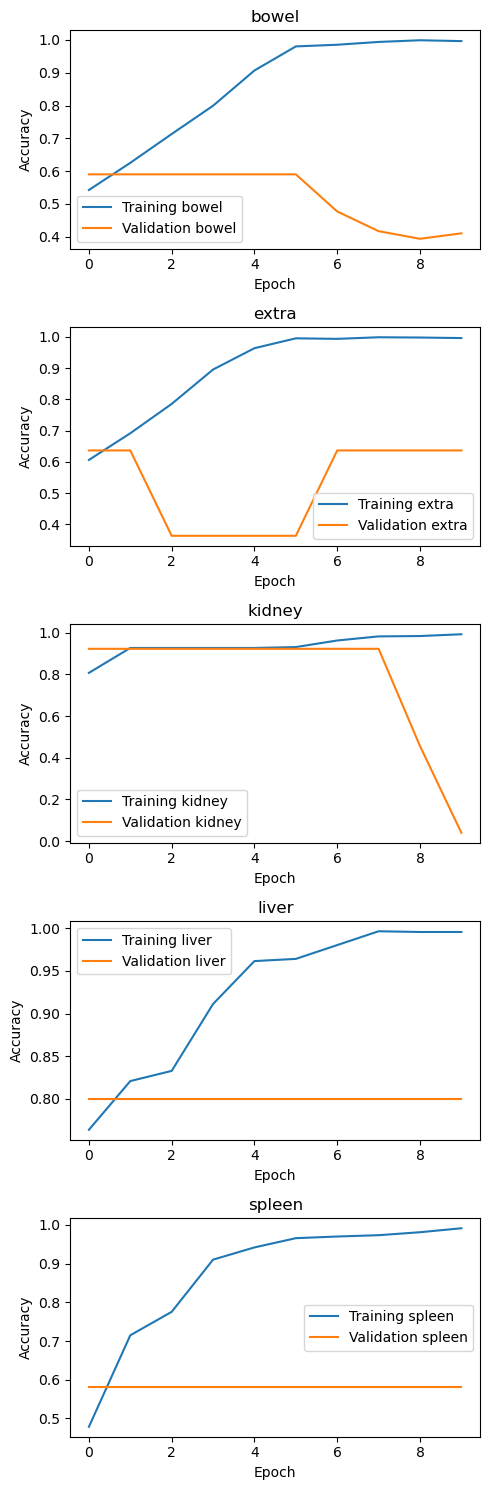

In [74]:
# Create a 3x2 grid for the subplots
fig, axes = plt.subplots(5, 1, figsize=(5, 15))

# Flatten axes to iterate through them
axes = axes.flatten()

# Iterate through the metrics and plot them
for i, name in enumerate(["bowel", "extra", "kidney", "liver", "spleen"]):
    # Plot training accuracy
    axes[i].plot(history.history[name + '_accuracy'], label='Training ' + name)
    # Plot validation accuracy
    axes[i].plot(history.history['val_' + name + '_accuracy'], label='Validation ' + name)
    axes[i].set_title(name)
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Accuracy')
    axes[i].legend()

plt.tight_layout()
plt.show()

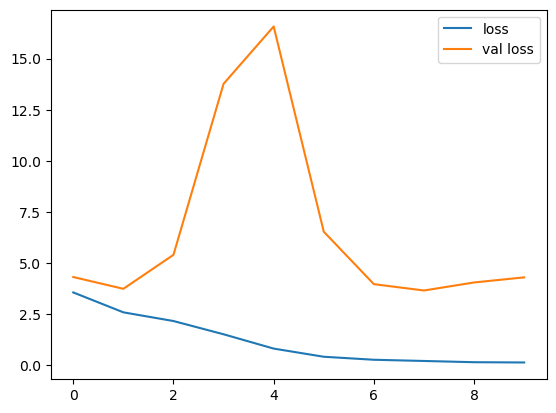

In [75]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend()
plt.show()

In [76]:
# store best results
best_epoch = np.argmin(history.history['val_loss'])
best_loss = history.history['val_loss'][best_epoch]
best_acc_bowel = history.history['val_bowel_accuracy'][best_epoch]
best_acc_extra = history.history['val_extra_accuracy'][best_epoch]
best_acc_liver = history.history['val_liver_accuracy'][best_epoch]
best_acc_kidney = history.history['val_kidney_accuracy'][best_epoch]
best_acc_spleen = history.history['val_spleen_accuracy'][best_epoch]

# Find mean accuracy
best_acc = np.mean(
    [best_acc_bowel,
     best_acc_extra,
     best_acc_liver,
     best_acc_kidney,
     best_acc_spleen
])


print(f'>>>> BEST Loss  : {best_loss:.3f}\n>>>> BEST Acc   : {best_acc:.3f}\n>>>> BEST Epoch : {best_epoch}\n')
print('ORGAN Acc:')
print(f'  >>>> {"Bowel".ljust(15)} : {best_acc_bowel:.3f}')
print(f'  >>>> {"Extravasation".ljust(15)} : {best_acc_extra:.3f}')
print(f'  >>>> {"Liver".ljust(15)} : {best_acc_liver:.3f}')
print(f'  >>>> {"Kidney".ljust(15)} : {best_acc_kidney:.3f}')
print(f'  >>>> {"Spleen".ljust(15)} : {best_acc_spleen:.3f}')

>>>> BEST Loss  : 3.662
>>>> BEST Acc   : 0.671
>>>> BEST Epoch : 7

ORGAN Acc:
  >>>> Bowel           : 0.417
  >>>> Extravasation   : 0.637
  >>>> Liver           : 0.800
  >>>> Kidney          : 0.923
  >>>> Spleen          : 0.580


In [77]:
# Save the model
model.save("rsna-atd.keras")

OSError: [Errno 28] No space left on device